## Import Libraries

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Reading Dataset

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

## Feature Engineering

### Creating a Distance Feature from Latitude and Longitude

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates
    """
    r = 6371 # average radius of Earth in kilometers

    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])

    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = r * c
    return d

In [5]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [6]:
df['dist_in_km'] = haversine_distance(
    df=df,
    lat1='pickup_latitude',
    long1='pickup_longitude',
    lat2='dropoff_latitude',
    long2='dropoff_longitude'
)

In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_in_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_in_km         120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


### Datetime Feature

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_in_km         120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [11]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_in_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [12]:
my_time = df['pickup_datetime'][0]

In [13]:
my_time.hour

8

In [14]:
my_time.day

19

### Creating EDT Date Feature

In [15]:
df['pickup_datetime_edt'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [16]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_in_km,pickup_datetime_edt
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


### Creating Hours and AM/PM Feature

In [17]:
df['hour'] = df['pickup_datetime_edt'].dt.hour
df['am_or_pm'] = np.where(df['hour'] < 12, 'am', 'pm')

In [18]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_in_km,pickup_datetime_edt,hour,am_or_pm
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm


### Creating Weekend and Weekday Feature

In [19]:
df['weekday'] = df['pickup_datetime_edt'].dt.strftime("%a")

In [20]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_in_km,pickup_datetime_edt,hour,am_or_pm,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


## Categorical and Continuous Features

In [21]:
cat_cols = ['hour', 'am_or_pm', 'weekday']
cont_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
             'dropoff_latitude', 'passenger_count', 'dist_in_km'
            ]

In [22]:
y_col = ['fare_amount']

In [23]:
df.dtypes

pickup_datetime        datetime64[ns, UTC]
fare_amount                        float64
fare_class                           int64
pickup_longitude                   float64
pickup_latitude                    float64
dropoff_longitude                  float64
dropoff_latitude                   float64
passenger_count                      int64
dist_in_km                         float64
pickup_datetime_edt    datetime64[ns, UTC]
hour                                 int32
am_or_pm                            object
weekday                             object
dtype: object

In [24]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [25]:
df.dtypes

pickup_datetime        datetime64[ns, UTC]
fare_amount                        float64
fare_class                           int64
pickup_longitude                   float64
pickup_latitude                    float64
dropoff_longitude                  float64
dropoff_latitude                   float64
passenger_count                      int64
dist_in_km                         float64
pickup_datetime_edt    datetime64[ns, UTC]
hour                              category
am_or_pm                          category
weekday                           category
dtype: object

In [26]:
df['hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [27]:
df['am_or_pm'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: am_or_pm, dtype: category
Categories (2, object): ['am', 'pm']

In [28]:
df['weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [29]:
df['am_or_pm'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

In [30]:
df['am_or_pm'].cat.categories

Index(['am', 'pm'], dtype='object')

In [31]:
df['weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

### Creating NumPy Arrays for Categorical Features

In [32]:
hour = df['hour'].cat.codes.values
am_or_pm = df['am_or_pm'].cat.codes.values
weekday = df['weekday'].cat.codes.values

In [33]:
cats = np.stack([hour, am_or_pm, weekday], axis=1)
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

### Converting NumPy Arrays to Tensor

In [34]:
cats = torch.tensor(cats, dtype=torch.int64)

In [35]:
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

### Creating NumPy Arrays for Continuous Features

In [36]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts

array([[-73.992365  ,  40.730521  , -73.975499  ,  40.744746  ,
          1.        ,   2.12631159],
       [-73.990078  ,  40.740558  , -73.974232  ,  40.744114  ,
          1.        ,   1.39230687],
       [-73.994149  ,  40.751118  , -73.960064  ,  40.766235  ,
          2.        ,   3.32676344],
       ...,
       [-73.988574  ,  40.749772  , -74.011541  ,  40.707799  ,
          3.        ,   5.05252282],
       [-74.004449  ,  40.724529  , -73.992697  ,  40.730765  ,
          1.        ,   1.20892296],
       [-73.955415  ,  40.77192   , -73.967623  ,  40.763015  ,
          3.        ,   1.42739869]])

### Converting NumPy Arrays to Tensor

In [37]:
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

### Converting a Label Column into Tensor

In [38]:
df[y_col].values

array([[ 6.5],
       [ 6.9],
       [10.1],
       ...,
       [12.5],
       [ 4.9],
       [ 5.3]])

In [39]:
y = torch.tensor(df[y_col].values, dtype=torch.float)
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

### Checking Shape of Each

In [40]:
cats.shape

torch.Size([120000, 3])

In [41]:
conts.shape

torch.Size([120000, 6])

In [42]:
y.shape

torch.Size([120000, 1])

## Setting Up Embedding

In [43]:
cat_size = [len(df[col].cat.categories) for col in cat_cols]
cat_size

[24, 2, 7]

In [44]:
embedding_size = [(size, min(50, (size+1) // 2)) for size in cat_size]
embedding_size

[(24, 12), (2, 1), (7, 4)]

## Passing Slice of Categorical Data into Embedding

In [45]:
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [46]:
[nn.Embedding(ni, nf) for ni, nf in embedding_size]

[Embedding(24, 12), Embedding(2, 1), Embedding(7, 4)]

## Creating Embedding Layer

In [47]:
self_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
self_embeddings

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [48]:
embeddingz = []

for i, e in enumerate(self_embeddings):
    embeddingz.append(e(catz[:, i]))

embeddingz

[tensor([[ 2.6725,  1.4482,  0.9614,  1.3346,  0.8048,  1.0167,  1.5270, -0.1037,
           2.2488,  1.0236, -0.7393,  0.8994],
         [ 0.2111,  0.3224, -0.3430, -1.5243, -1.3332, -0.0955, -0.2264,  1.0658,
           1.6075, -0.6903, -0.4638,  1.0315],
         [ 1.1934, -0.1411, -0.5356, -1.5555, -0.6197, -1.6265, -0.5041, -0.6288,
           1.1217,  0.8607, -1.2688,  0.2823],
         [ 1.3858,  0.4627,  1.5347,  0.0687,  0.6834, -2.1023, -0.7844, -0.0148,
          -1.0960,  0.8049,  0.4284, -2.0486]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.1389],
         [-0.1389],
         [-0.1389],
         [ 0.0413]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.8770, -1.3164,  0.6131,  1.7588],
         [ 0.0977, -0.4305, -1.2899,  0.9209],
         [ 0.0977, -0.4305, -1.2899,  0.9209],
         [-0.8678,  0.5326,  0.6234,  0.9131]], grad_fn=<EmbeddingBackward0>)]

In [49]:
z = torch.cat(embeddingz, dim=1)
z

tensor([[ 2.6725,  1.4482,  0.9614,  1.3346,  0.8048,  1.0167,  1.5270, -0.1037,
          2.2488,  1.0236, -0.7393,  0.8994, -0.1389, -0.8770, -1.3164,  0.6131,
          1.7588],
        [ 0.2111,  0.3224, -0.3430, -1.5243, -1.3332, -0.0955, -0.2264,  1.0658,
          1.6075, -0.6903, -0.4638,  1.0315, -0.1389,  0.0977, -0.4305, -1.2899,
          0.9209],
        [ 1.1934, -0.1411, -0.5356, -1.5555, -0.6197, -1.6265, -0.5041, -0.6288,
          1.1217,  0.8607, -1.2688,  0.2823, -0.1389,  0.0977, -0.4305, -1.2899,
          0.9209],
        [ 1.3858,  0.4627,  1.5347,  0.0687,  0.6834, -2.1023, -0.7844, -0.0148,
         -1.0960,  0.8049,  0.4284, -2.0486,  0.0413, -0.8678,  0.5326,  0.6234,
          0.9131]], grad_fn=<CatBackward0>)

## Creating Dropout Layer

In [50]:
self_embedding_drop = nn.Dropout(p=0.4)

In [51]:
z = self_embedding_drop(z)
z

tensor([[ 4.4541,  2.4136,  0.0000,  0.0000,  1.3413,  1.6944,  0.0000, -0.0000,
          3.7480,  1.7060, -1.2322,  1.4989, -0.2315, -0.0000, -0.0000,  1.0219,
          2.9314],
        [ 0.3518,  0.5374, -0.5717, -2.5405, -2.2220, -0.1592, -0.3773,  1.7763,
          2.6792, -1.1505, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -2.1499,
          0.0000],
        [ 1.9890, -0.2351, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -1.0480,
          1.8695,  0.0000, -0.0000,  0.4706, -0.0000,  0.1628, -0.0000, -2.1499,
          1.5348],
        [ 2.3097,  0.7712,  2.5578,  0.1145,  1.1390, -3.5038, -0.0000, -0.0246,
         -0.0000,  0.0000,  0.7140, -0.0000,  0.0000, -0.0000,  0.8876,  0.0000,
          0.0000]], grad_fn=<MulBackward0>)

## Creating Tabular Model

In [52]:
class TabularModel(nn.Module):
    def __init__(self, embedding_size, num_of_cont_feats, out_size, layers, p=0.5):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_drop = nn.Dropout(p)
        self.batch_normalize_cont_feat = nn.BatchNorm1d(num_of_cont_feats)

        layers_list = []
        num_of_embeddings = sum([nf for ni, nf in embedding_size])
        num_of_input = num_of_embeddings + num_of_cont_feats

        for i in layers:
            layers_list.append(nn.Linear(num_of_input, i))
            layers_list.append(nn.ReLU(inplace=True))
            layers_list.append(nn.BatchNorm1d(i))
            layers_list.append(nn.Dropout(p))
            num_of_input = i

        layers_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layers_list)

    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embeddings):
            embeddings.append(e(x_cat[:, i]))

        x = torch.cat(embeddings, 1)
        x = self.embedding_drop(x)

        x_cont = self.batch_normalize_cont_feat(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

## Training the Model

In [53]:
torch.manual_seed(33)
model = TabularModel(
    embedding_size=embedding_size,
    num_of_cont_feats=conts.shape[1],
    out_size=1,
    layers=[200, 100],
    p=0.4
)

model

TabularModel(
  (embeddings): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (embedding_drop): Dropout(p=0.4, inplace=False)
  (batch_normalize_cont_feat): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [54]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [56]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]

cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [57]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [58]:
len(cat_train)

48000

In [59]:
len(cont_train)

48000

In [60]:
len(cat_test)

12000

In [61]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1

    # Forward Pass
    y_pred = model(cat_train, cont_train)

    # Calculating Loss
    loss = torch.sqrt(criterion(y_pred, y_train))

    # Recording Error
    losses.append(loss.detach().numpy())

    if i % 10 == 1:
        print(f"epoch is {i} and loss is {loss.item()}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print(f"Training Took {duration / 60} minutes")

epoch is 1 and loss is 12.586893081665039
epoch is 11 and loss is 11.686624526977539
epoch is 21 and loss is 11.12124252319336
epoch is 31 and loss is 10.7335844039917
epoch is 41 and loss is 10.460492134094238
epoch is 51 and loss is 10.2349214553833
epoch is 61 and loss is 10.028074264526367
epoch is 71 and loss is 9.849199295043945
epoch is 81 and loss is 9.635123252868652
epoch is 91 and loss is 9.413418769836426
epoch is 101 and loss is 9.17275619506836
epoch is 111 and loss is 8.894512176513672
epoch is 121 and loss is 8.57868480682373
epoch is 131 and loss is 8.216811180114746
epoch is 141 and loss is 7.808204174041748
epoch is 151 and loss is 7.365363597869873
epoch is 161 and loss is 6.919065475463867
epoch is 171 and loss is 6.455702304840088
epoch is 181 and loss is 5.967177867889404
epoch is 191 and loss is 5.460626602172852
epoch is 201 and loss is 5.016528129577637
epoch is 211 and loss is 4.630451202392578
epoch is 221 and loss is 4.341211795806885
epoch is 231 and loss 

Text(0.5, 0, 'Epoch')

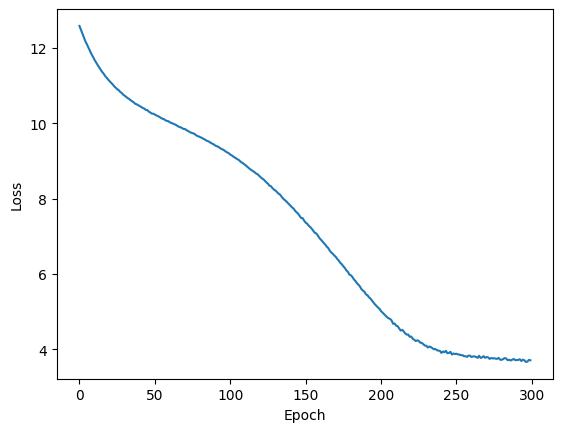

In [62]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

## Validate the Model

In [63]:
with torch.no_grad():
    y_eval = model.forward(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_eval, y_test))

In [64]:
loss

tensor(3.6336)

In [65]:
for i in range(10):
    difference = np.abs(y_eval[i].item() - y_test[i].item())
    print(f"{i}.) PREDICTED: {y_eval[i].item():8.2f} TRUE:{y_test[i].item():8.2f} DIFFERENCE:{difference:8.2f}")

0.) PREDICTED:     5.33 TRUE:    2.90 DIFFERENCE:    2.43
1.) PREDICTED:    13.36 TRUE:    5.70 DIFFERENCE:    7.66
2.) PREDICTED:     8.06 TRUE:    7.70 DIFFERENCE:    0.36
3.) PREDICTED:    14.56 TRUE:   12.50 DIFFERENCE:    2.06
4.) PREDICTED:     7.01 TRUE:    4.10 DIFFERENCE:    2.91
5.) PREDICTED:     6.25 TRUE:    5.30 DIFFERENCE:    0.95
6.) PREDICTED:     2.01 TRUE:    3.70 DIFFERENCE:    1.69
7.) PREDICTED:    18.79 TRUE:   14.50 DIFFERENCE:    4.29
8.) PREDICTED:     5.16 TRUE:    5.70 DIFFERENCE:    0.54
9.) PREDICTED:    13.80 TRUE:   10.10 DIFFERENCE:    3.70


## Saving the Model

In [66]:
torch.save(model.state_dict(), 'taxi_fare_amount.pt')